# Zaimportowane biblioteki i lista analizowanych plików

In [1]:
#docrepr
ip = get_ipython()
ip.sphinxify_docstring = True
ip.enable_html_pager = True

In [2]:
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
files = sorted(glob('data/*.xls'))

files  #lista plików

['data\\0.000.xls',
 'data\\0.200.xls',
 'data\\0.535.xls',
 'data\\0.535X.xls',
 'data\\0.743.xls']

# Skrypt odczytujący i przetwarzający dane z plików

In [4]:
def process(file_path):
    """
    file_path has to be str
    """

    init_data = pd.read_excel(file_path)
    data = init_data[['Date&Time', 'Unit']]
    values = []

    for i in init_data['MainValue']:
        value = i.replace(',', '.')
        values.append(float(value))

    data.insert(loc=1, column='Value', value=values)

    minutes = []
    means300s = []
    errors = []

    mean30m = data['Value'][-9000::900].mean()
    err30m = data['Value'][-9000::900].sem()
    n = data['Value'][::6000].count()
    meanfull = data['Value'][::6000].mean()
    errfull = data['Value'][::6000].sem()

    minute = 0

    while not data.empty:
        minutes.append(minute)
        minute += 1
        means300s.append(data['Value'][:300].mean())
        errors.append(data['Value'][:300].sem())
        data = data[300:]

    final_df = pd.DataFrame(
        {
            'minute': minutes,
            'mean300s': means300s,
            'error': errors,
            'mean30m': mean30m,
            'error30m': err30m,
            'meanfull': meanfull,
            'errfull': errfull,
            'n': n
        }
    )

    return final_df

# Skrypty rysujące wykresy

Wykres zależności napięcia od czasu. Różne serie danych reprezentują hodowle o różnych gęstościach optycznych.

data\0.000.xls t = 218    218
Name: minute, dtype: int64 min
data\0.200.xls t = 218    218
Name: minute, dtype: int64 min
data\0.535.xls t = 218    218
Name: minute, dtype: int64 min
data\0.535X.xls t = 218    218
Name: minute, dtype: int64 min
data\0.743.xls t = 158    158
Name: minute, dtype: int64 min


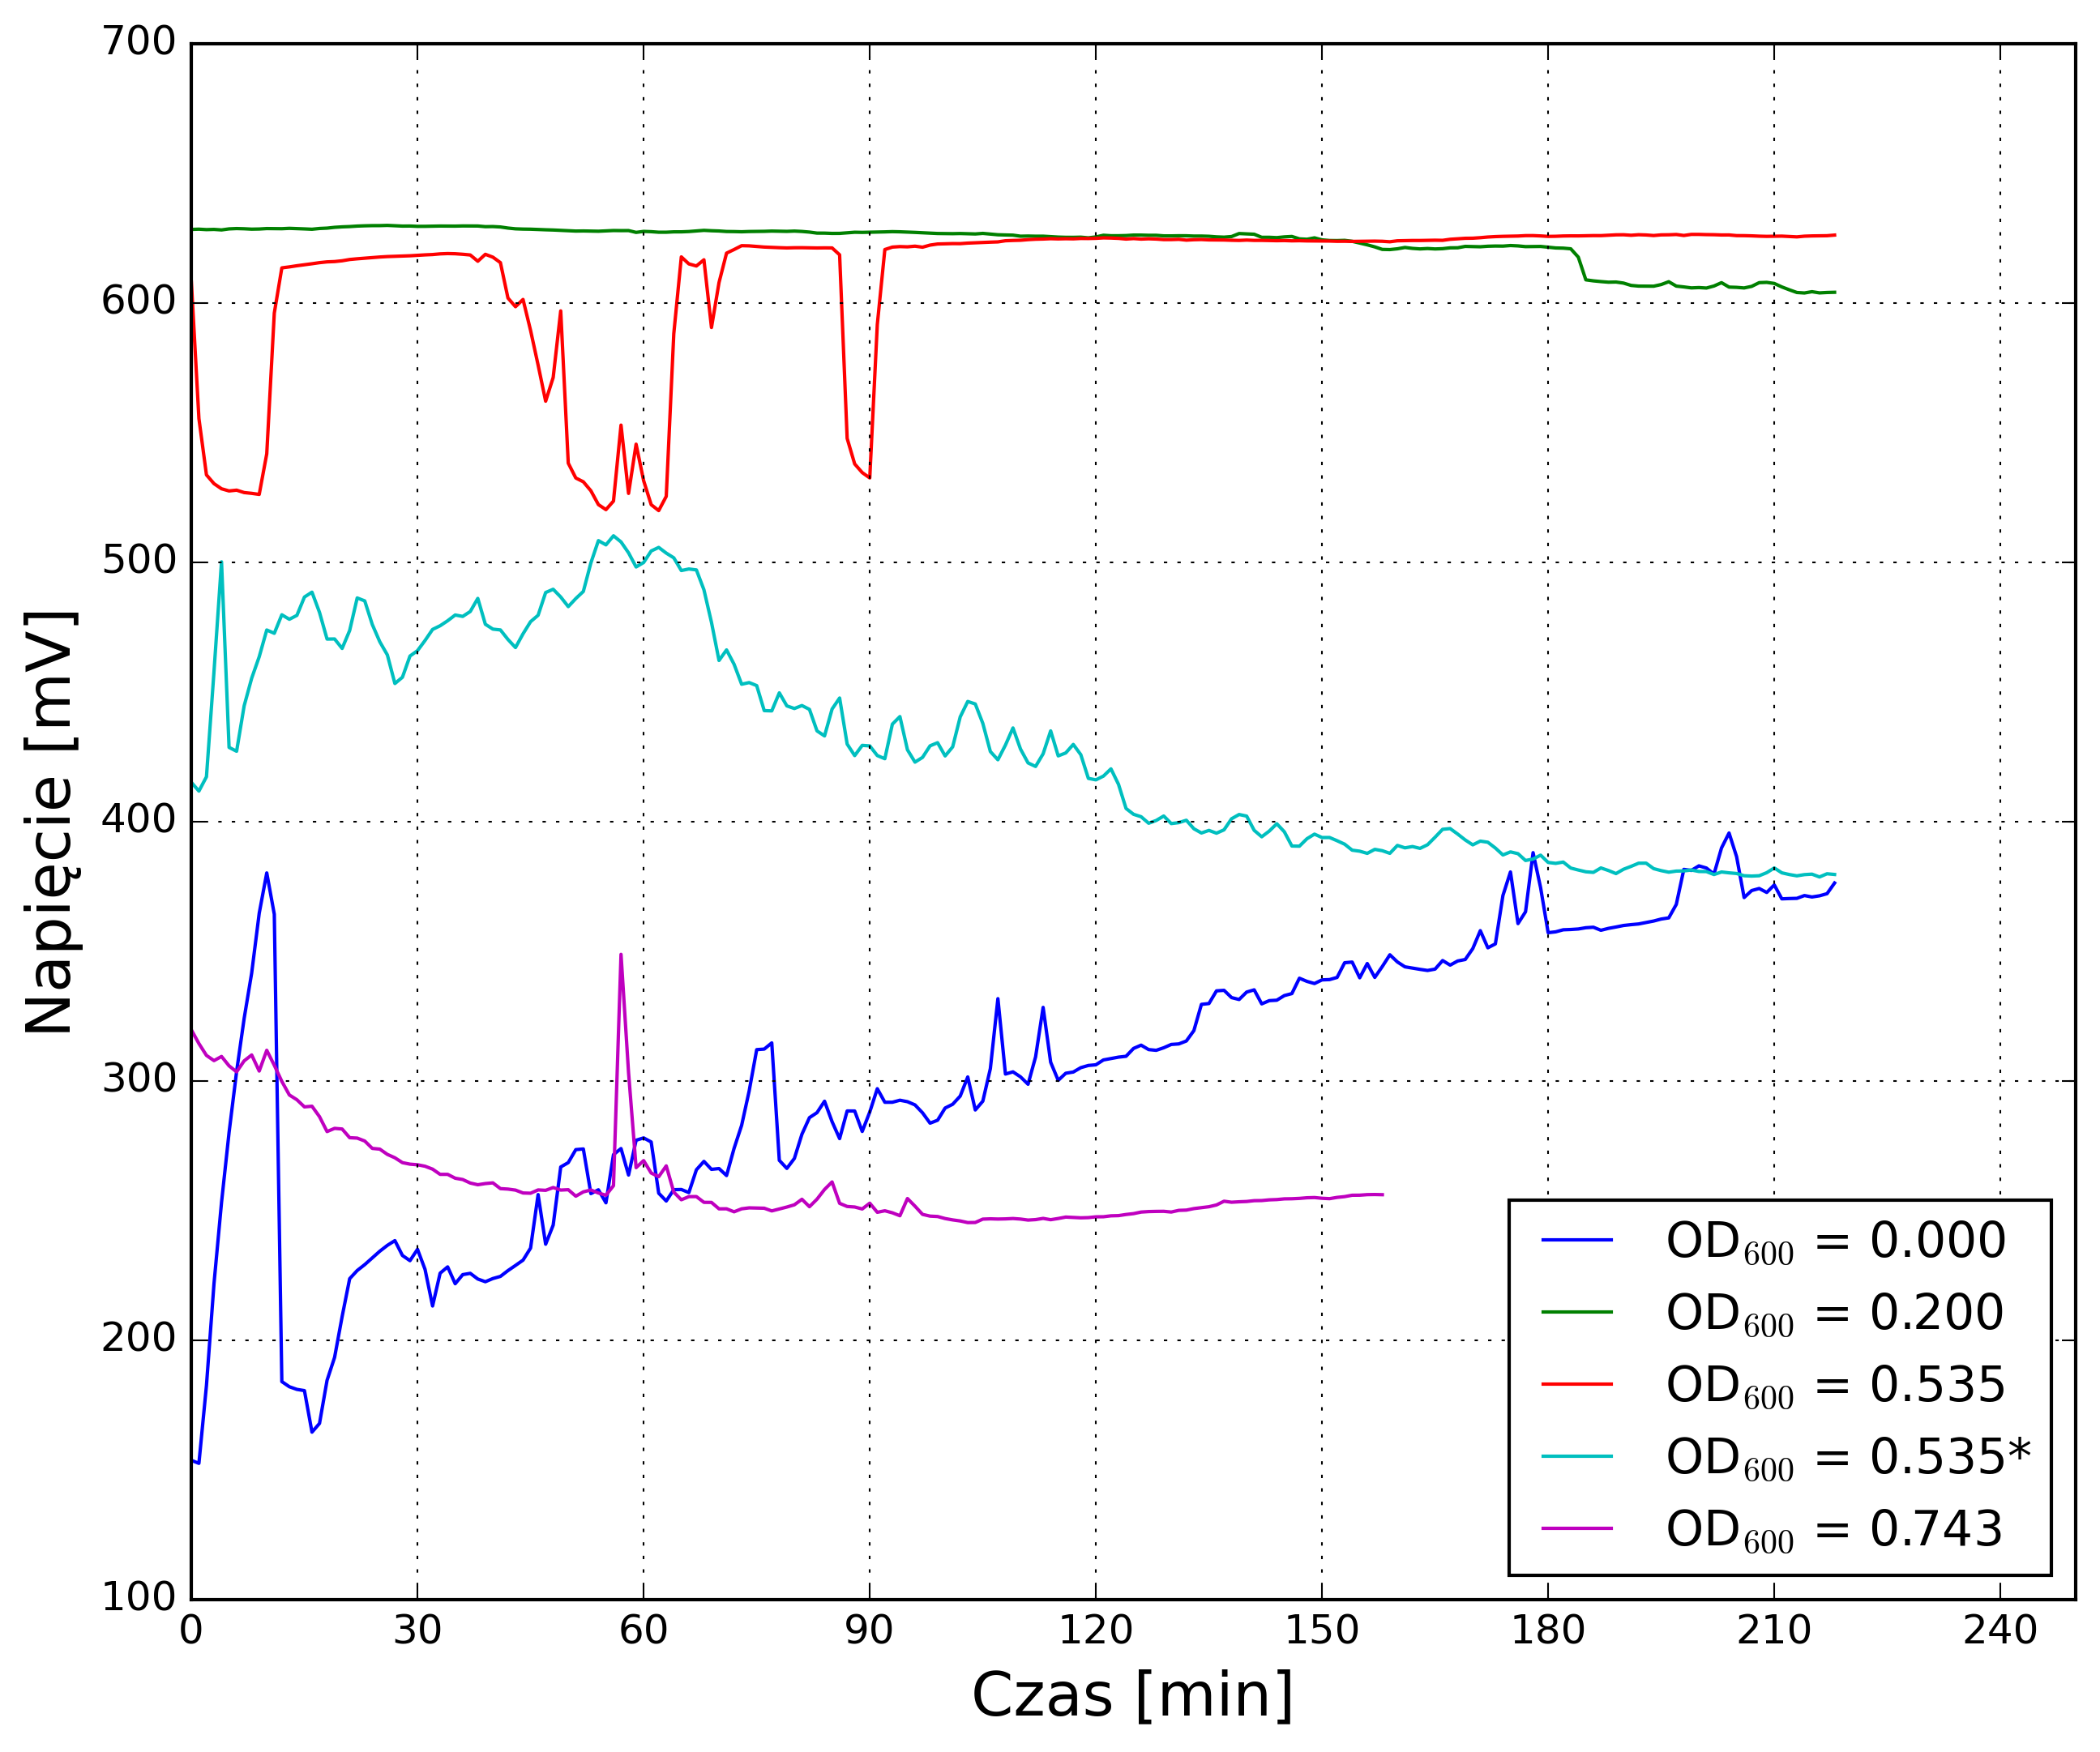

In [11]:
plt.style.use('classic')

fig1 = plt.figure(figsize=(10, 8), dpi=300, facecolor='#ffffff')

legend = []
factor = 1

for file in files:
    final_df = process(file)
    print(f'{file} t = {final_df["minute"].tail(1)} min')

    plt.errorbar(
        x=final_df['minute'],
        y=final_df['mean300s'] * factor,
        # yerr = final_df['error'],
        fmt='-',
    )

    if 'X' in file:
        file = file.replace('X', '*')
    series_name = 'OD$_{600}$ = ' + f'{file[5:-4]}'
    legend.append(series_name)
    factor = 1000

plt.ylabel(
    'Napięcie [mV]',
    fontdict={'fontsize': 18}
)
plt.xlabel(
    'Czas [min]',
    fontdict={'fontsize': 18}
)
plt.legend(legend, loc='lower right')
plt.grid()
plt.xticks([0, 30, 60, 90, 120, 150, 180, 210, 240])
fig1.savefig('../manuscript/figures/voltage1.png', bbox_inches='tight')
plt.show()
plt.close(fig1)

Wykres słupkowy przedstawiający uśrednione napięcie z ostatnich 30 minut pomiaru dla różnych gęstości hodowli. Słupki błędu to SEM.

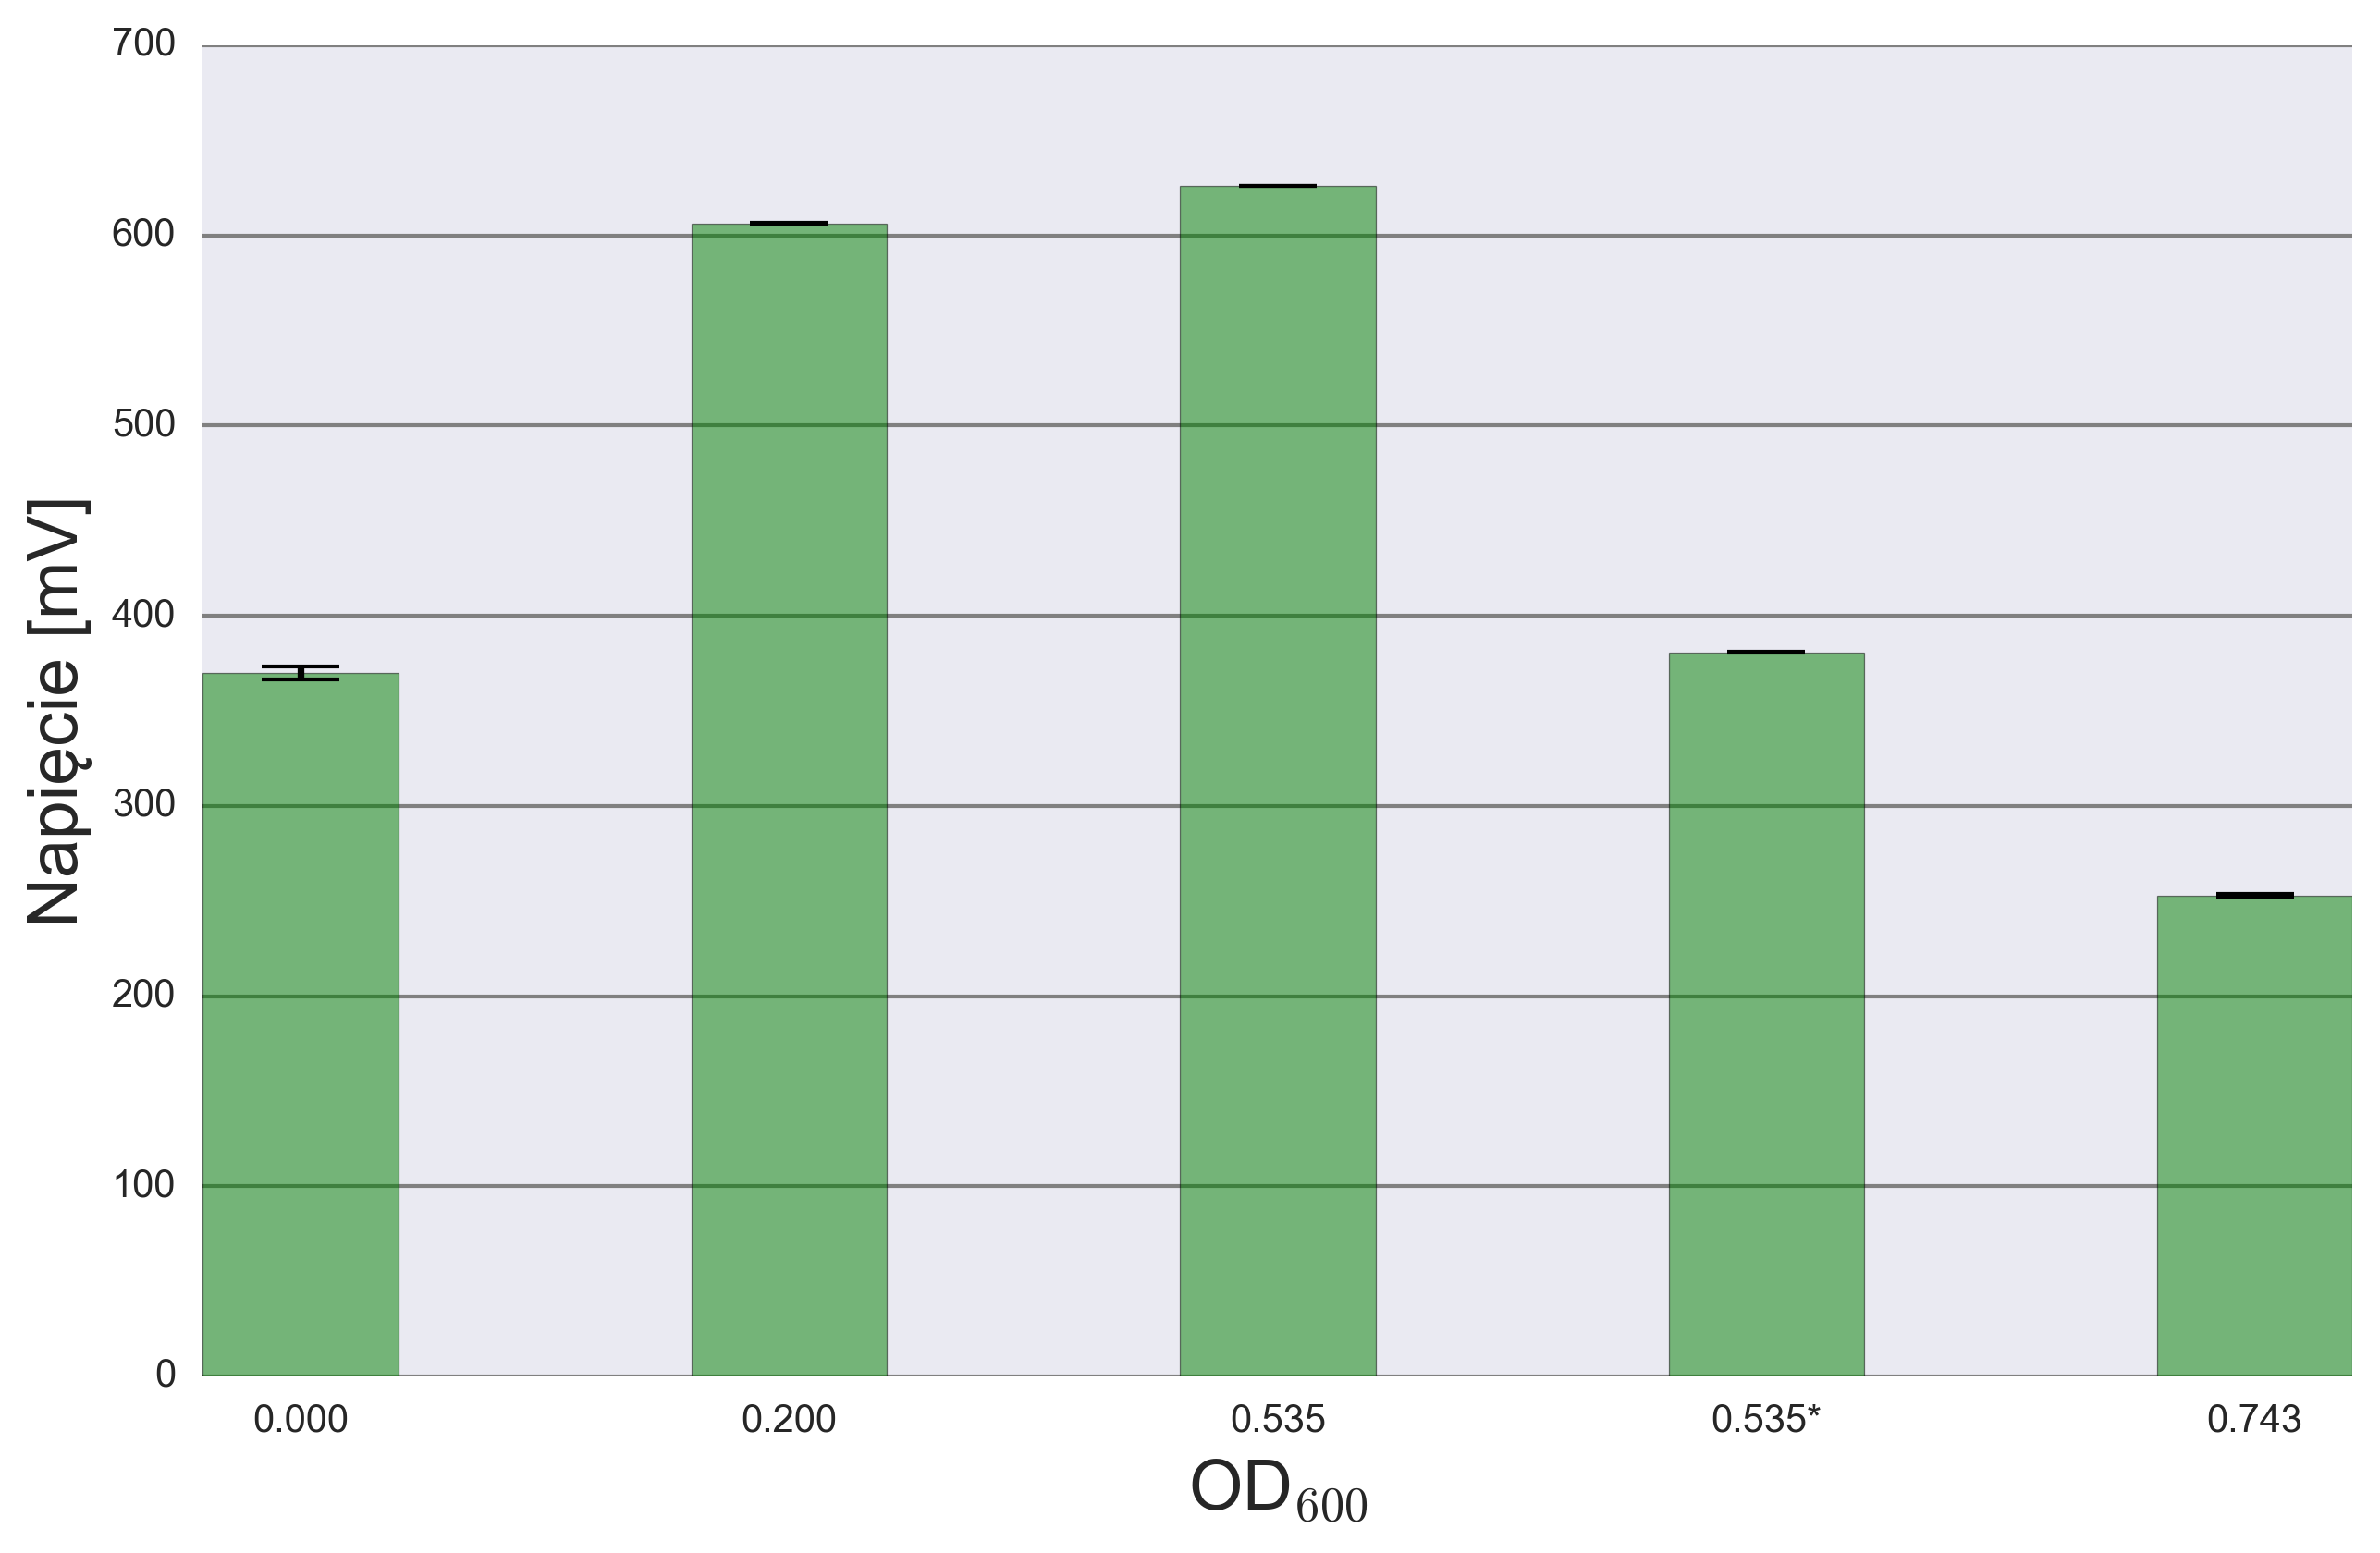

In [6]:
plt.style.use('seaborn')
plt.rcParams.update({'lines.markeredgewidth': 1})
fig2, ax = plt.subplots(figsize=(10, 6), dpi=300, facecolor='#ffffff')

factor = 1
for file in files:
    final_df = process(file)

    if 'X' in file:
        file = file.replace('X', '*')
    series_name = f'{file[5:-4]}'

    ax.bar(
        x=series_name,
        height=final_df['mean30m'][1] * factor,
        yerr=final_df['error30m'][1] * factor,
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=10,
        color='green',
        width=0.4,
    )
    factor = 1000
ax.grid(False)
ax.grid(axis='y', color='grey')
ax.set_ylabel('Napięcie [mV]', fontdict={'fontsize': 18})
ax.set_xlabel('OD$_{600}$', fontdict={'fontsize': 18})
fig2.savefig('../manuscript/figures/voltage2.png', bbox_inches='tight')
plt.show()
plt.close(fig2)

Wykres słupkowy przedstawiający uśrednione napięcie z całego pomiaru dla różnych gęstości hodowli. Słupki błędu to SEM.

data\0.000.xls n = 11
data\0.200.xls n = 11
data\0.535.xls n = 11
data\0.535X.xls n = 11
data\0.743.xls n = 8


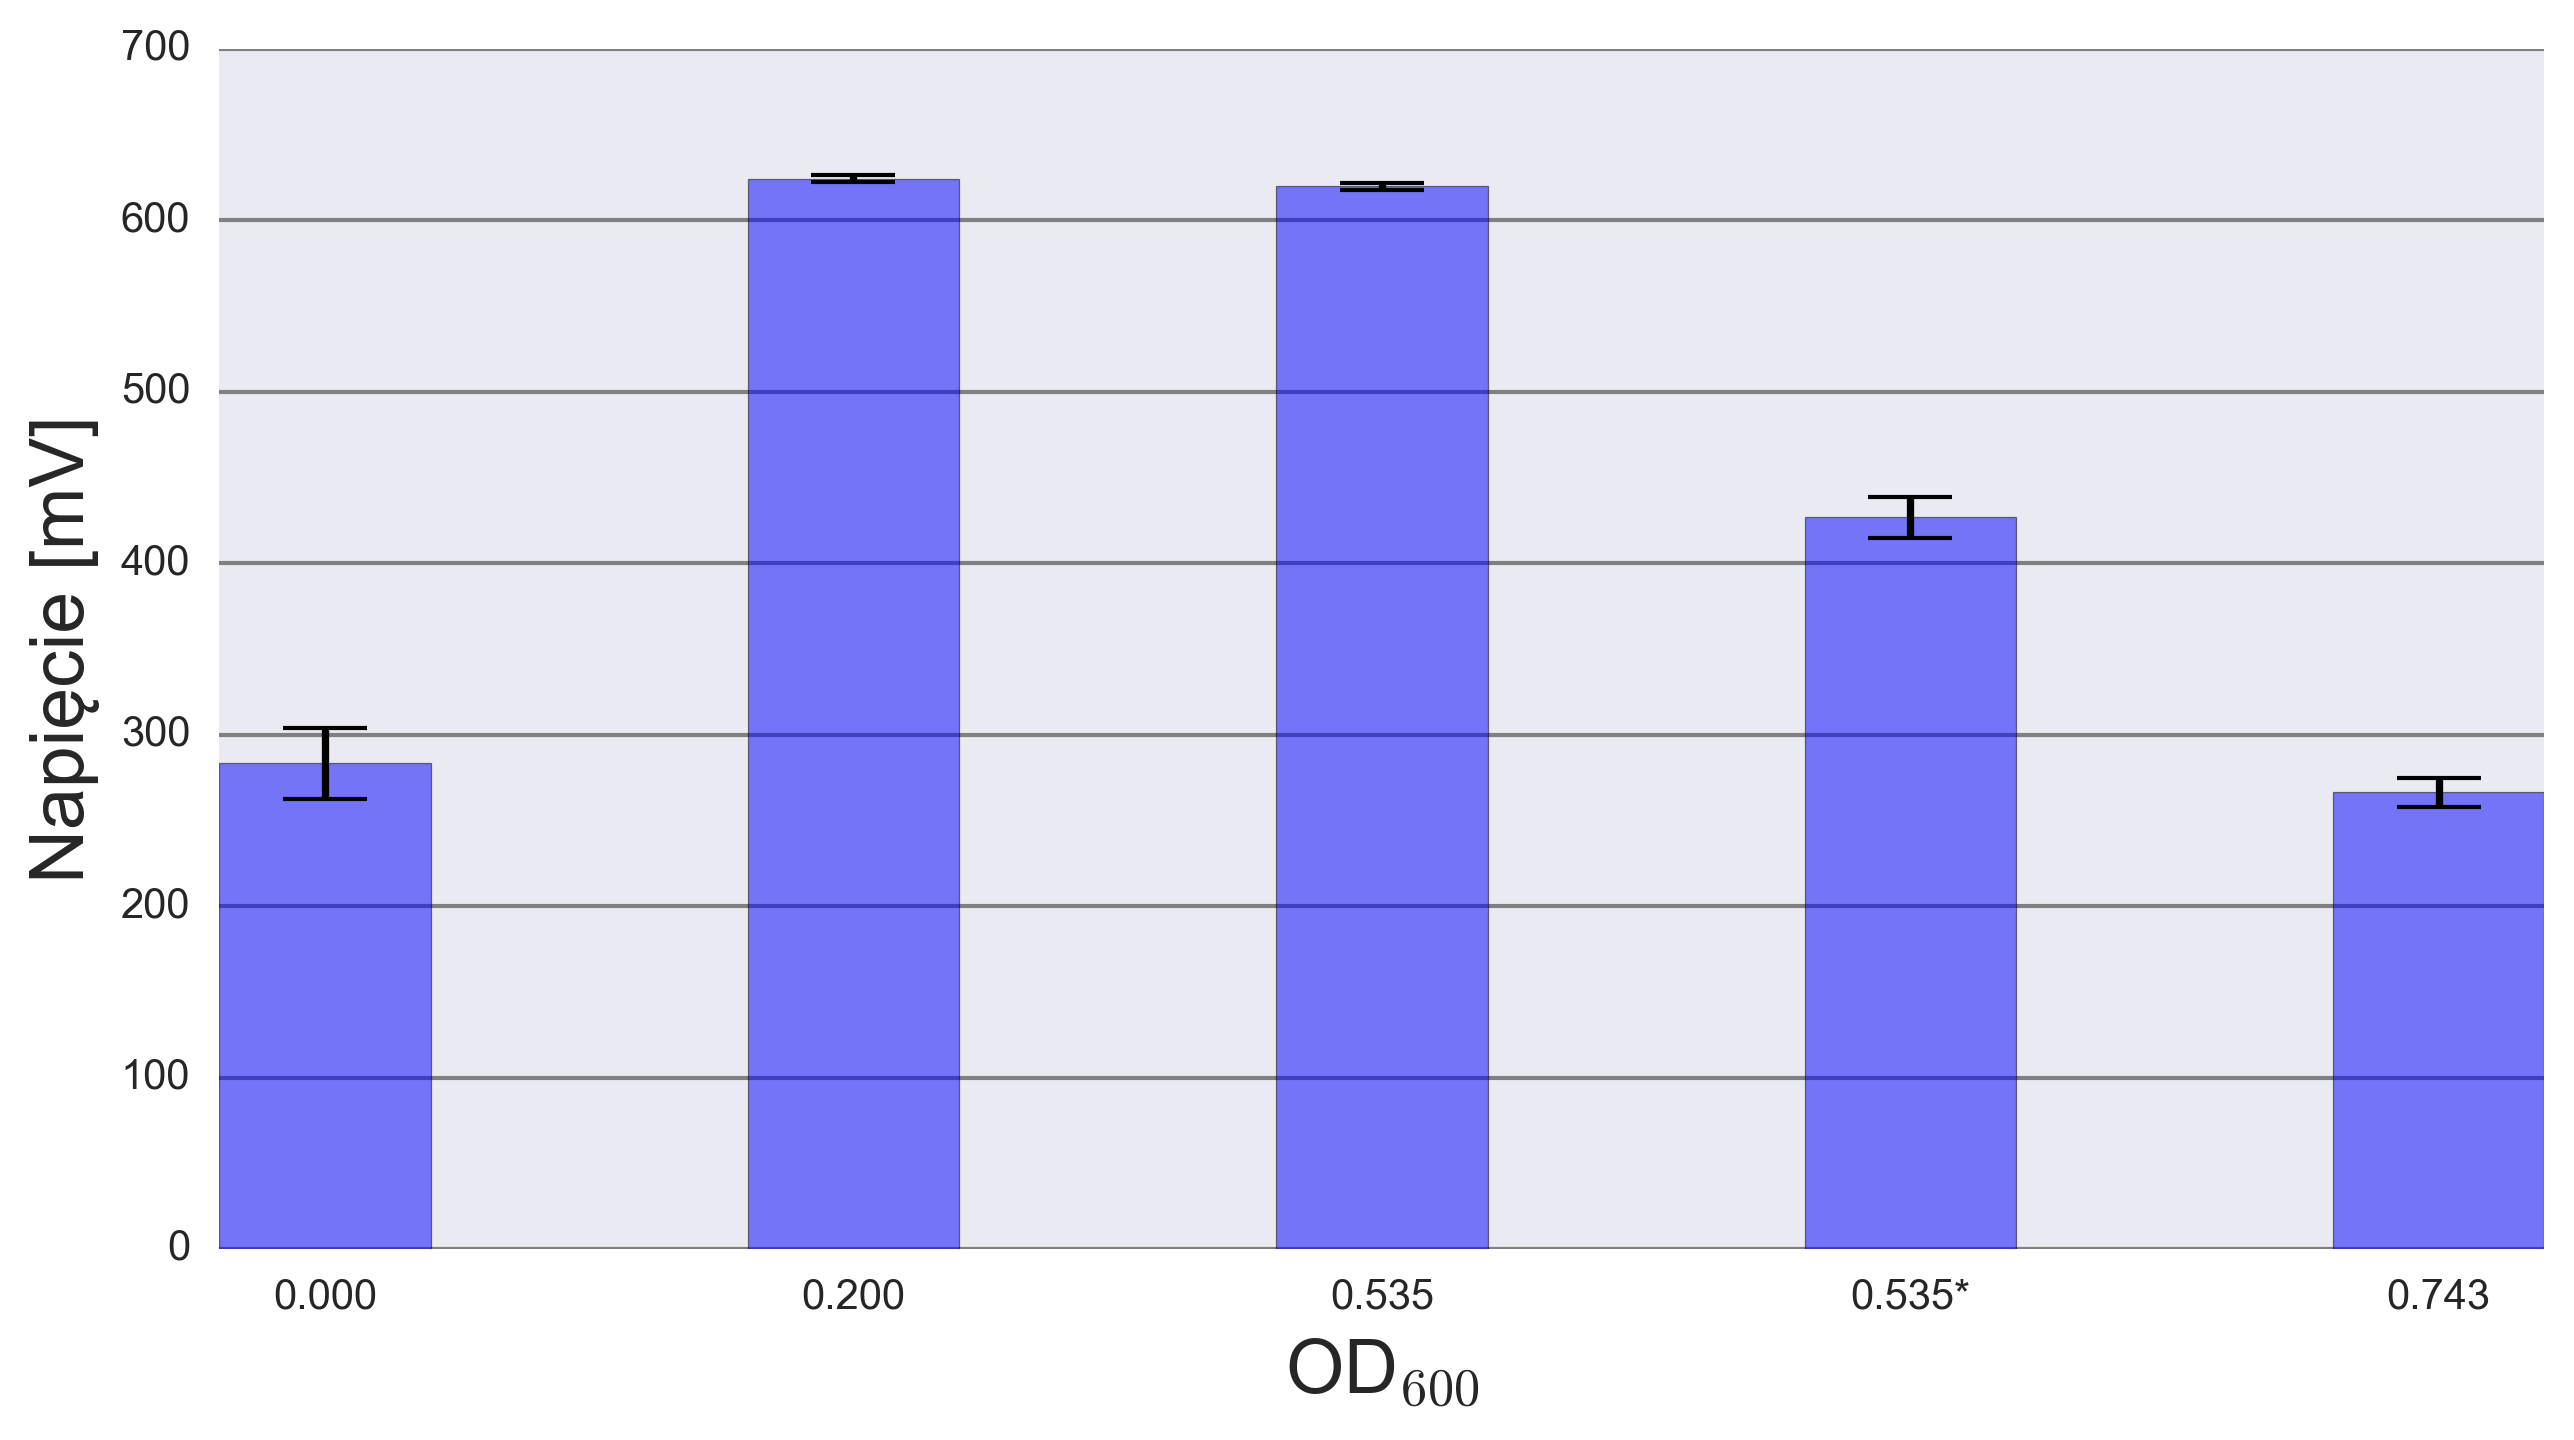

In [7]:
fig3, ax = plt.subplots(figsize=(10, 5), dpi=300, facecolor='#ffffff')

factor = 1
for file in files:
    final_df = process(file)
    print(f'{file} n = {final_df["n"][1]}')

    if 'X' in file:
        file = file.replace('X', '*')
    series_name = f'{file[5:-4]}'

    ax.bar(
        x=series_name,
        height=final_df['meanfull'][1] * factor,
        yerr=final_df['errfull'][1] * factor,
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=10,
        color='blue',
        width=0.4
    )
    factor = 1000
ax.grid(False)
ax.grid(axis='y', color='grey')
ax.set_ylabel('Napięcie [mV]', fontdict={'fontsize': 18})
ax.set_xlabel('OD$_{600}$', fontdict={'fontsize': 18})
fig3.savefig('../manuscript/figures/voltage3.png', bbox_inches='tight')
plt.show()
plt.close(fig3)

\*pomiar wykonano po 24 h adaptacji mikroorganizmów do elektrody

In [8]:
VALUES = []
factor = 1
for file in files:
    values = []
    df = pd.read_excel(file)
    for i in df['MainValue']:
        value = i.replace(',', '.')
        values.append(float(value)*factor)
    VALUES.append(values)
    factor = 1000
VALUE_DICT = {
    '0.000': VALUES[0][:len(VALUES[4]):158],
    '0.200': VALUES[1][:len(VALUES[4]):158],
    '0.535': VALUES[2][:len(VALUES[4]):158],
    '0.535*': VALUES[3][:len(VALUES[4]):158],
    '0.743': VALUES[4][:len(VALUES[4]):158],
}

In [9]:
df = pd.DataFrame(data=VALUE_DICT)

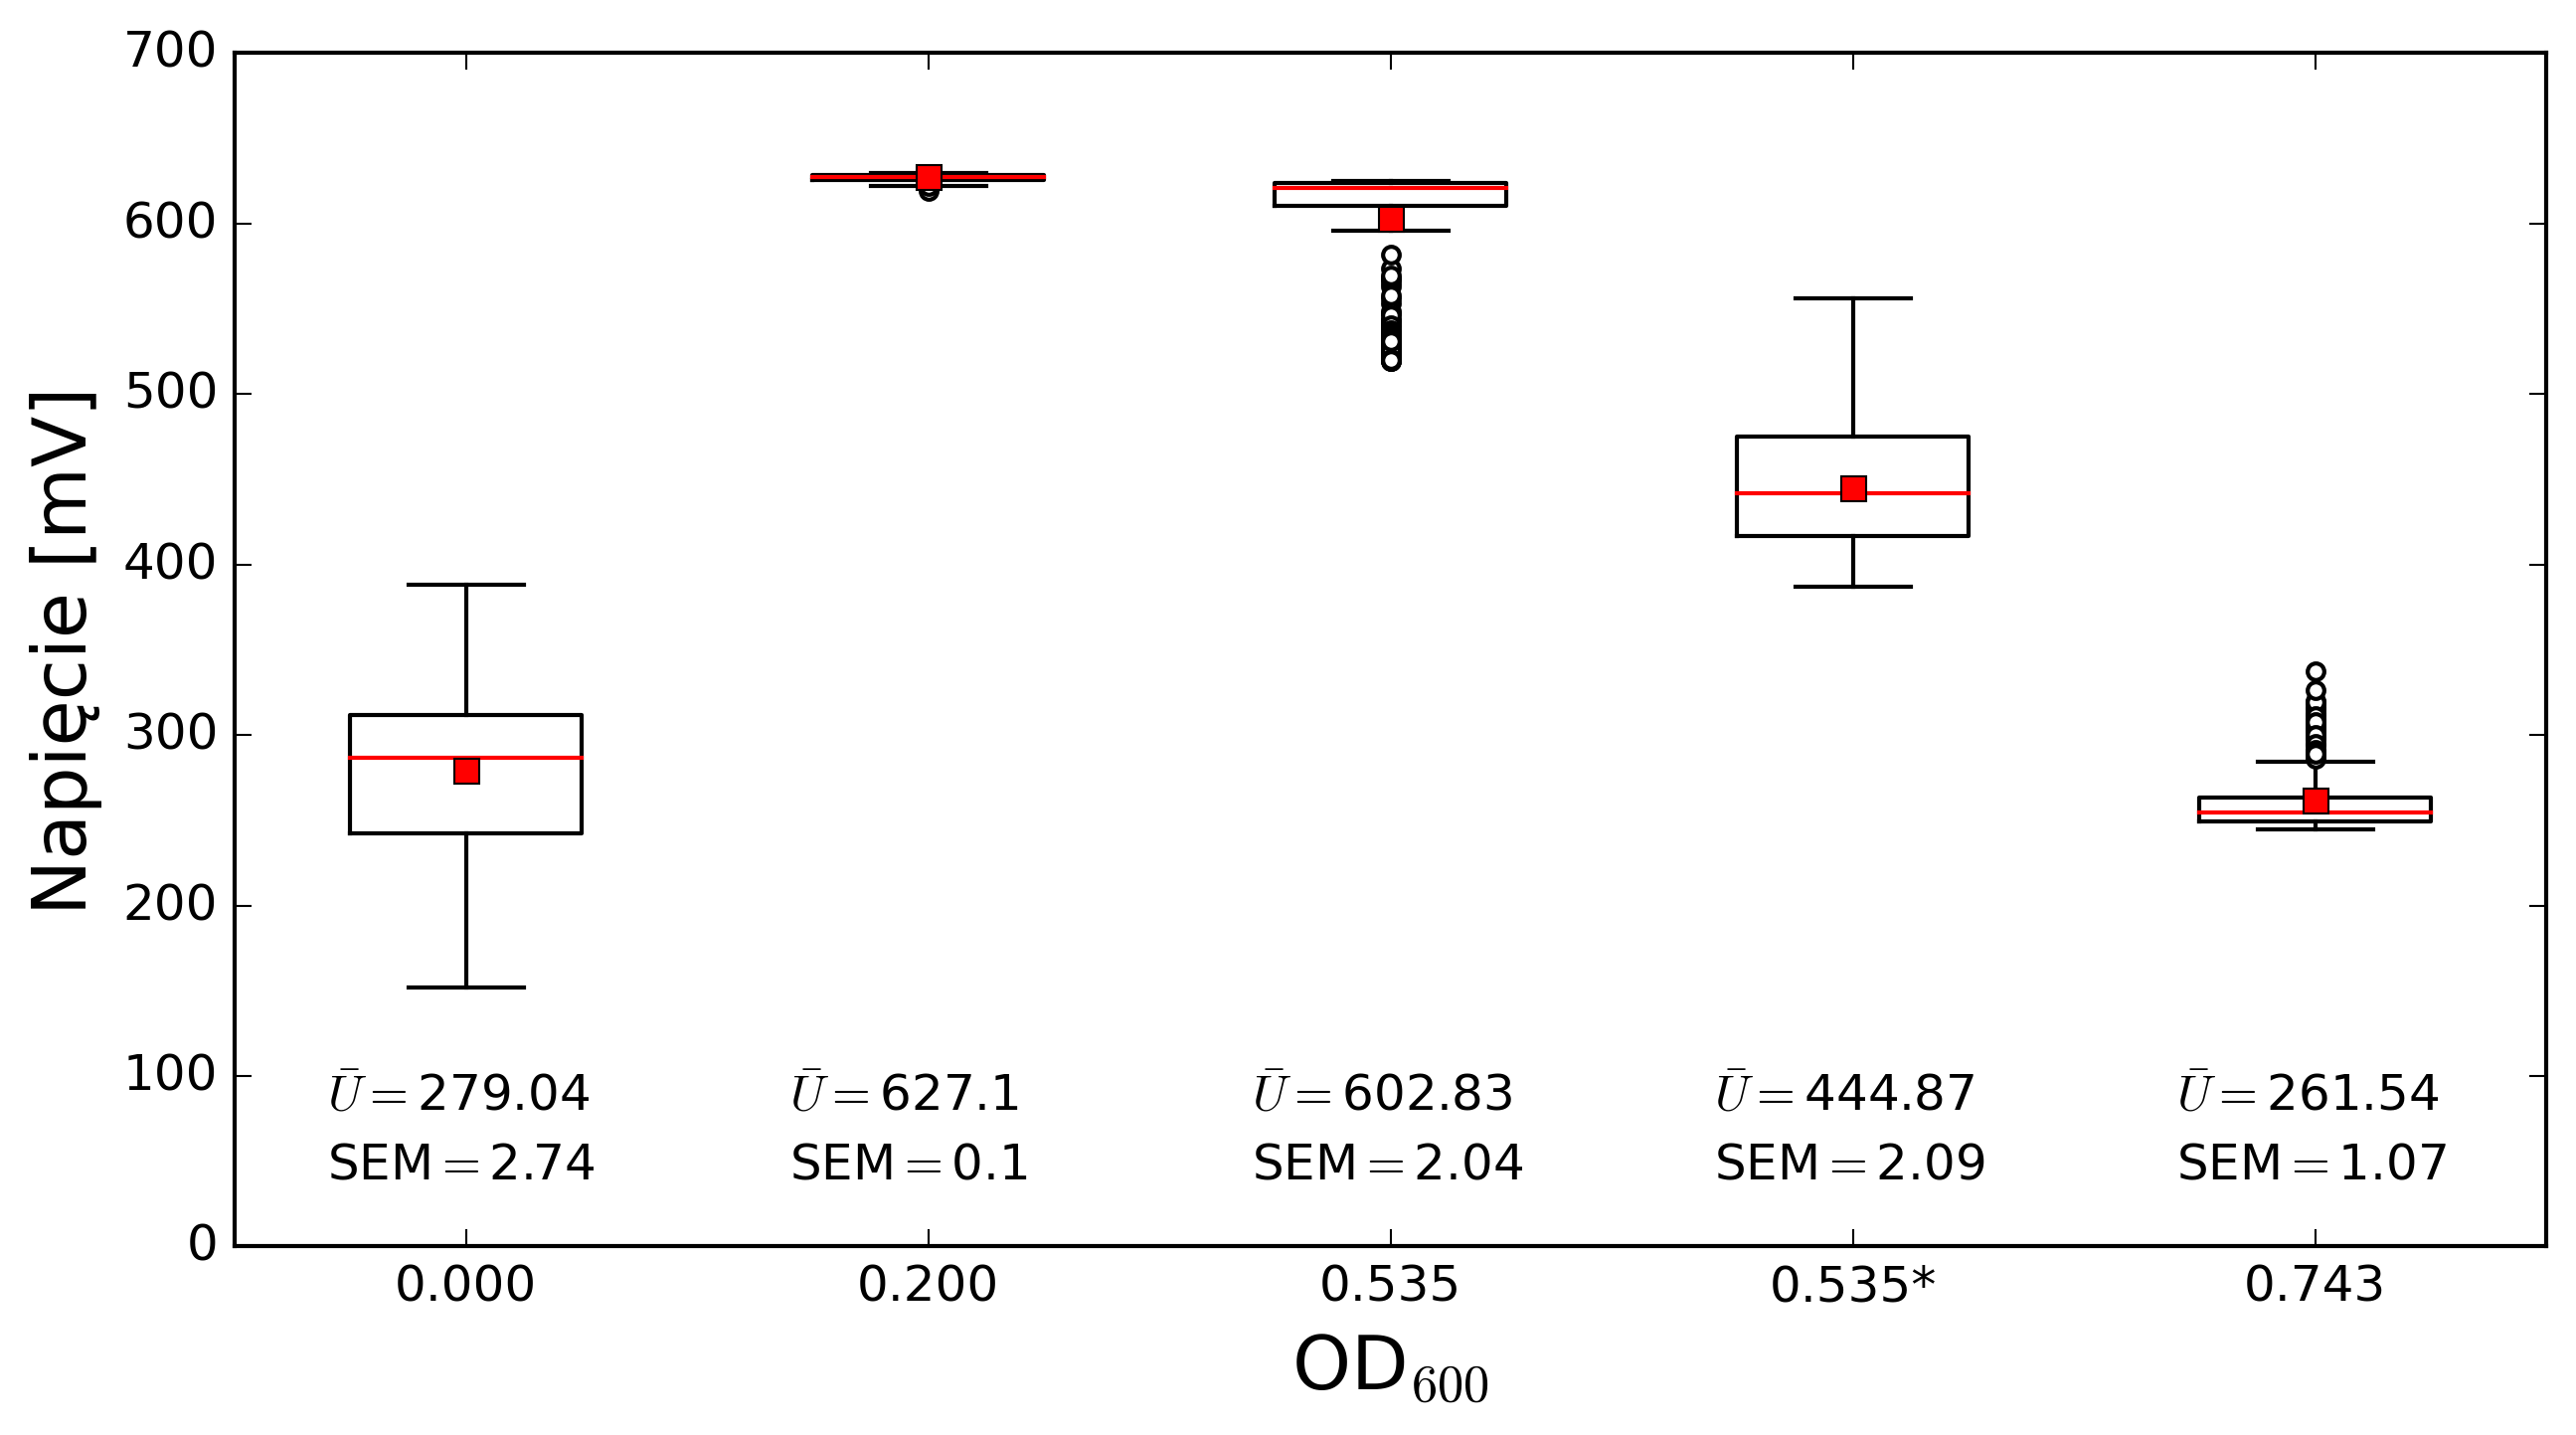

In [10]:
plt.style.use('classic')
fig, ax = plt.subplots(figsize=(10, 5), dpi=300, facecolor='#ffffff')

ax.boxplot(
    x=df,
    labels=['0.000', '0.200', '0.535', '0.535*', '0.743'],
    showmeans=True,
    flierprops={'marker': 'o', 'markersize': 4, 'color': 'white', 'linestyle': 'none'},
    boxprops={'color': 'black'},
    whiskerprops={'linestyle': '-', 'color': 'black'}
)
ax.set_ylim(0,700)
ax.set_ylabel('Napięcie [mV]', fontdict={'fontsize': 18})
ax.set_xlabel('OD$_{600}$', fontdict={'fontsize': 18})
ax.text(x=0.70, y=80, s=r'$\bar{U} = $' + f"{round(df['0.000'].mean(), 2)}")
ax.text(x=1.70, y=80, s=r'$\bar{U} = $' + f"{round(df['0.200'].mean(), 2)}")
ax.text(x=2.70, y=80, s=r'$\bar{U} = $' + f"{round(df['0.535'].mean(), 2)}")
ax.text(x=3.70, y=80, s=r'$\bar{U} = $' + f"{round(df['0.535*'].mean(), 2)}")
ax.text(x=4.70, y=80, s=r'$\bar{U} = $' + f"{round(df['0.743'].mean(), 2)}")

ax.text(x=0.70, y=40, s='SEM$ = $' + f"{round(df['0.000'].sem(), 2)}")
ax.text(x=1.70, y=40, s='SEM$ = $' + f"{round(df['0.200'].sem(), 2)}")
ax.text(x=2.70, y=40, s='SEM$ = $' + f"{round(df['0.535'].sem(), 2)}")
ax.text(x=3.70, y=40, s='SEM$ = $' + f"{round(df['0.535*'].sem(), 2)}")
ax.text(x=4.70, y=40, s='SEM$ = $' + f"{round(df['0.743'].sem(), 2)}")
plt.savefig('../manuscript/figures/mfc-volt-boxplt.png', bbox_inches='tight')
plt.show()